# TRABAJO PRÁCTICO 3 - Regresión Logística.

In [76]:
#Librerías

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Exploración de datos

shape: entrenamiento 	 X: (60000, 28, 28) 	 Y: (60000,)
shape: test 	 X: (10000, 28, 28) 	 Y: (10000,)


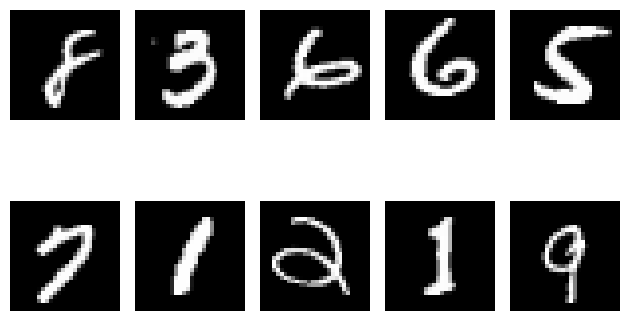

In [77]:
(x_train, y_train), (x_test, y_test) = mnist.load_data ()

print('shape: entrenamiento','\t X:', x_train.shape, '\t Y:',y_train.shape)
print('shape: test','\t X:', x_test.shape, '\t Y:',y_test.shape)

n_img = 10
pos_index = np.arange(x_train.shape[0])
random_index = np.random.choice(pos_index, size=10, replace=False) #Se toman 10 indices diferentes de todos los posibles

for i in range(n_img):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[random_index[i]],cmap = 'gray')
    plt.axis("off")
plt.tight_layout()

#1 -> impares  y 0 -> pares
categorical_train = y_train %2
categorical_test = y_test %2

# Preprocesamiento

In [78]:
class Normalizar : 
    def __init__ (self):
        self.mean = None
        self.var = None
        self.mask = None
    
    def fit(self, X):
        self.mean = np.mean(X, axis=0).astype(np.float32) #Se calcula la media a través de las 60k img (axis 0)
        self.var = np.var(X, axis=0).astype(np.float32)    

        X_c = np.copy(X) #Se genera una copia para no modificar los datos originales
        X_c = X_c.reshape(X_c.shape[0],-1).astype(np.float32) #Se cambia el tamaño para tener un array de 60k x 784
        self.var = self.var.reshape(-1) #Se construye la fila de 784 elementos a partir del 28x28
        self.mean = self.mean.reshape(-1) #Se construye la fila de 784 elementos a partir del 28x28
        
        self.mask = (self.var> 0.0)   #Se genera una máscara, para conservar los pixeles con varianzas mayores a 0.0

    def transform(self, X):
        X_c = np.copy(X) #Se genera una copia para no modificar los datos originales
        X_c = X_c.reshape(X_c.shape[0],-1).astype(np.float32) #Se cambia el tamaño para tener un array de 60k x 784
        
        #Se aplica la máscara a los datos copia y a las varianzas
        X_c = X_c[:,self.mask]
        var_c = self.var[self.mask]
        mean_c = self.mean[self.mask]
        
        for i in range (var_c.shape[0]): #Se normalizan los pixeles
            X_c[:,i] = (X_c[:,i] - mean_c[i])/(np.sqrt(var_c[i]))
        
        return X_c

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    



##### Se aplica la normalización a los conjuntos de datos

In [79]:
norm = Normalizar()

# Train data
x_train_norm = norm.fit_transform(x_train)

# Test data
x_test_norm = norm.transform(x_test)

print(x_train_norm.shape, x_test_norm.shape)


(60000, 717) (10000, 717)


# Regresión Logística

In [80]:
class RegresionLogistica:
    def __init__(self,learning_rate,iterations):
        self.learning_rate = learning_rate #Learning rate del gradiente descendiente
        self.iterations = iterations
        self.theta = None #Vector de parámetros del gradiente descendiente
        self.emp_risk = None
        
    def sigmoid(self,z):
        return 1/(1+np.exp(-z))

    def fit(self, X,y):
        n_samples, n_features = X.shape #Se obtienen los tamaños del vector X (cantidad de imagenes y cantidad de pixeles) con el bias agregado
        self.theta = np.zeros(n_features) #Se inicializa el vector de parámetros con 0, se tendrá un parámetros para cada pixel
        self.emp_risk = np.zeros(self.iterations) #Se inicializa el vector de riesgo empírico

        for i in range (self.iterations):
            y_pred = self.sigmoid(X @ self.theta)
            grad = (1/n_samples) * X.T @ (y_pred-y) #Se calcula el gradiente para todo el dataset
            self.theta -= self.learning_rate * grad #Se actualiza el vector de parámetros
            self.emp_risk[i] = self.cross_entropy(X,y) #Se guarda la entropia cruzada

    #testeo soft
    def predict_proba (self, X):
        return self.sigmoid(X @ self.theta)
    
    #testeo hard
    def predict(self, X):
        y_proba = self.predict_proba(X) #Se obtienen las probabilidades de pertenecer a cada clase
        probs = np.column_stack([1 - y_proba, y_proba]) #Se obtiene la probabilidad de cada muestra de pertenecer a la clase 0 o 1 respectivamente
        return np.argmax(probs,axis=1) #Se retorna a que clase pertenece cada muestra en función de la máxima probabilidad previa
        
    def accuracy (self, X, y):
        y_predict = self.predict(X)
        return np.mean(y_predict == y)

    def cross_entropy (self,X,y):
        y_proba = self.predict_proba(X)
        return -np.mean(y * np.log(y_proba) + (1 - y) * np.log(1 - y_proba))
        

#### Entrenamiento y testeo

accuracy de entrenamiento: 0.8993
accuracy de testeo: 0.8986
entropía de entrenamiento: 0.2549
entropía de testeo: 0.258


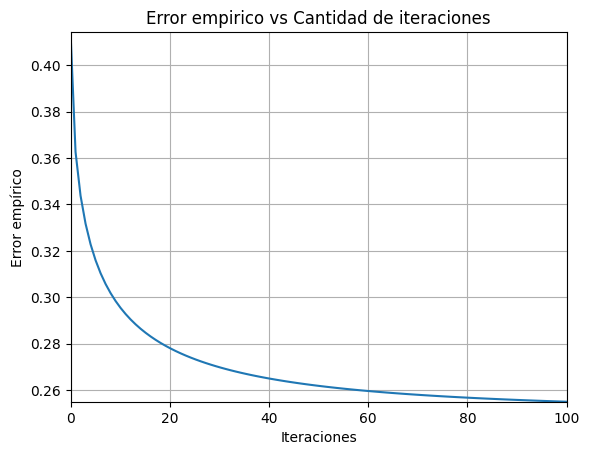

In [81]:

N=100
learning_rate = 0.2
model = RegresionLogistica(learning_rate,N)

#Se agrega la columna de bias
x_train_norm = np.insert(x_train_norm, 0, 1, axis=1) 
x_test_norm = np.insert(x_test_norm, 0, 1, axis=1)


model.fit(x_train_norm,categorical_train)

# accuracy de entrenamiento
acc_train = model.accuracy(x_train_norm, categorical_train)

# accuracy de testeo
acc_test = model.accuracy(x_test_norm, categorical_test)

print('accuracy de entrenamiento:', round(acc_train,4))
print('accuracy de testeo:', round(acc_test,4))


cross_entropy_train = model.cross_entropy(x_train_norm,categorical_train) 
cross_entropy_test = model.cross_entropy(x_test_norm,categorical_test)

print('entropía de entrenamiento:', round(cross_entropy_train,4))
print('entropía de testeo:', round(cross_entropy_test,4))

n = np.linspace(0,N,N)
plt.plot(n,model.emp_risk)
plt.title('Error empirico vs Cantidad de iteraciones')
plt.xlabel('Iteraciones')
plt.ylabel('Error empírico')
plt.xlim([0,100])
plt.ylim([np.min(model.emp_risk),np.max(model.emp_risk)])
plt.grid(True)


# Curva ROC

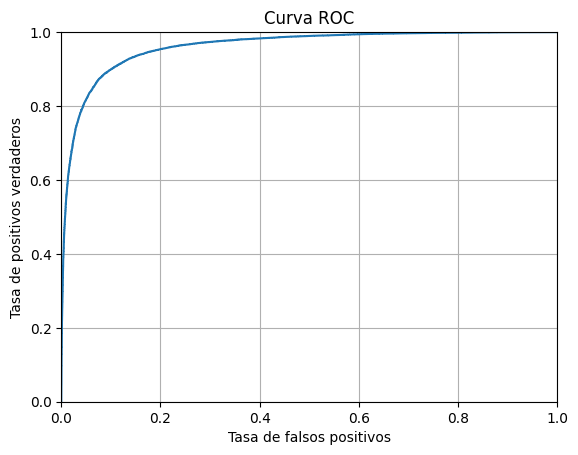

In [82]:
y_scores = model.predict_proba(x_train_norm) #X posee la columna de bias
y_true = categorical_train

thresholds = np.sort(np.unique(y_scores))[::-1] #Se seleccionan los umbrales, evitando repeticiones y se los ordena de forma descendente

P = np.sum(y_true == 1) #Se obtienen la cantidad de positivos reales
N = np.sum(y_true == 0) #Se obtienen la cantidad de negativos reales

tpr_list = []
fpr_list = []

for thr in thresholds:
    y_pred = (y_scores >= thr).astype(int) #Se buscan las probabilidades mayores que el umbral

    #La predicción da 1 y el verdadero 0 -> falso positivo
    #La predicción da 1 y el verdadero 1 -> positivo verdadero
    TP = np.sum((y_pred == 1) & (y_true == 1)) #Se calcula la cantidad de positivos verdaderos
    FP = np.sum((y_pred == 1) & (y_true == 0)) #Se calcula la cantidad de falsos positivos

    TPR = TP / P #Se calculan TPR y FPR para este valor umbral
    FPR = FP / N 

    tpr_list.append(TPR)    #Se cargan en las listas
    fpr_list.append(FPR)

plt.plot(fpr_list, tpr_list)
plt.xlabel("Tasa de falsos positivos")
plt.ylabel('Tasa de positivos verdaderos')
plt.title('Curva ROC')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid(True)

# Desarrollos teóricos

### Cálculo de la función inversa de la función Sigmoide $\sigma$(z)

La función sigmoide se define como: $\sigma(z) = \frac{1}{1+e^{-z}}$

Si se llama $p = \sigma (z)$ y se despeja $z$ en función de $p$, se tiene:

$p$ $(1+e^{-z}) = 1$

$(1+e^{-z}) = \frac{1}{p}$

$e^{-z} = \frac{1}{p} - 1 $ 

$z = -ln|\frac{1-p}{p}|$

y finalmente, dado que $p$ $\in$ $(0,1)$ y a las propiedades del logaritmo :

$z=ln(\frac{p}{1-p})$

entonces:

$\sigma^{-1}(p) = ln(\frac{p}{1-p})$

### Cálculo de la derivada $\sigma'(z)$

siguiendo con la misma notación: $p=\sigma(z)$

$\sigma'(z) = \frac{d}{dz} (\frac{1}{1+e^{-z}}) = \frac{d}{dz} (1+e^{-z})^{-1} = -1(1+e^{-z})^{-2} (-e^{-z}) = \frac{e^{-z}}{(1+e^{-z})^2}$

luego, escribiendo en términos de $p$:

$\frac{e^{-z}}{(1+e^{-z})^2}$ $\rightarrow$ $p^2 e ^{ln(\frac{1-p}{p})}$ $ = p^2 (\frac{1-p}{p})$

finalmente, la derivada es:

$\sigma'(p) = p-p^2$

### Función de costos asociada a una regresión logística de 2 clases

tomando:

$p(x) = P_{Y|X=x}(1)$

$P_{Y|X=x}(0) = 1-p(x)$

Donde, $Y$ es una variable Bernoulli, que puede tomar valores $0$ y $1$.

Para garantizar que la estimación se encuentre entre 0 y 1, se considera:

$p(x)= \sigma (\omega^T x +b)$, donde $\sigma(z)$ es la función Sigmoide



Luego, la función de costos en función de los datos $x$ y la variable $y$, es: $l(x,y) = -log(\hat{P}(y|x))$

por lo que queda expresada según:

$l(x,y) = -(1-y) log(1-\sigma (\omega^T x +b)) - y log(\sigma (\omega^T x +b))$

luego, el gradiente de la misma, respecto a las variables $b$ y $\omega$ vale:

$\frac{\partial}{\partial \omega } l(x,y) = x (\sigma (\omega^T x +b) - y) $

$\frac{\partial}{\partial b } l(x,y) = \sigma (\omega^T x +b) - y $

